# Predicting interior style from image and text

In [2]:
import csv
import finder
import os
from PIL import Image
from shutil import copy2
import operator
import pickle
from numpy.linalg import norm
import numpy as np

In [20]:
FEATURE_EXTRACTION_MODEL = "resnet"
RESULTS_DIRECTORY = 'style_dataset/processed_images/results'
TEST_DIRECTORY = 'style_dataset/processed_images/test'

In [9]:
w2v_model = pickle.load(open('pickles/style_w2v_model.p', 'rb'))
style_words_dict = pickle.load(open('pickles/style_words_dict.p', 'rb'))

In [10]:
TEST_SET_TEXT2 = ['cherry', 'wood', 'art', 'glamorous', 'carefree', 'ethnic',  'trendy', 'cool', 'mix', 'eclectic',
          'metal', 'brick',
          'mid-century', 'rusty',
          'japanese', 'simplicity',
          'modern', 'clean',
          'warm', 'relaxing',
          'lumber', 'stone',
          'organic', 'scandi',
          'soft', 'feminine',
          'elegant', 'symmetry',
         ]

In [11]:
TEST_SET_TEXT = ['glamorous', 'avant-garde', '1950s', 'bare', 'mix', 'metal', 'simplicity', 'relaxed', 'handcrafted', 'scandi', 'soft', 'symmetry']

In [12]:
TEST_SET_TEXT1 = ['art', 'carefree', 'cherry', 'elegant', 'feminine', 'lumber', 'metal', 'mid-century', 'mix',
 'organic', 'relaxing', 'simplicity','trendy', 'urban']

### Auxiliary functions

In [13]:
ground_truth_text = {'art': 'art deco',
    'glamorous' : 'art deco',
 'carefree': 'bohemian',
        'ethnic' : 'bohemian',
 'cherry': 'american colonial',
'wood' : 'american colonial',
 'elegant': 'traditional',
'symmetry': 'traditional',
 'feminine': 'shabby chic',
   'soft': 'shabby chic',
 'lumber': 'rustic',
 'stone': 'rustic',
 'metal': 'industrial',
 'brick': 'industrial',
 'mid-century': 'century modern',
    'rusty': 'century modern',
 'mix': 'eclectic',
 'eclectic': 'eclectic',
 'organic': 'scandinavian',
'scandi': 'scandinavian',
 'relaxing': 'nautical',
 'warm': 'nautical',
 'simplicity': 'minimalist',
'japanese': 'minimalist',
 'trendy': 'contemporary',
     'cool': 'contemporary',
 'urban': 'modern',
     'modern': 'modern',
    'clean': 'modern'}

In [14]:
INTERIOR_STYLES = []
for word in ground_truth_text.values():
    if word not in INTERIOR_STYLES:
        INTERIOR_STYLES.append(word)
print(INTERIOR_STYLES)

['art deco', 'bohemian', 'american colonial', 'traditional', 'shabby chic', 'rustic', 'industrial', 'century modern', 'eclectic', 'scandinavian', 'nautical', 'minimalist', 'contemporary', 'modern']


### Word2vec functions

In [15]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = word2vec.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in X if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
        ])
    
def cosine(u, v):
    u, v = np.array(u, dtype="float32").flatten(), np.array(v, dtype="float32").flatten()
    dist = np.dot(u, v) / (norm(u) * norm(v))
    return dist

def find_style(transformed_query, style_words_dict, model):
    similarities = {}
    for style in style_words_dict:
        similarities[style] = list()
        for word in style_words_dict[style]:
                similarities[style].append(cosine(model.wv[word], transformed_query))
    return similarities

def predict_n_styles(text, style_words_dict, model, n):
    vectorizer = MeanEmbeddingVectorizer(model)
    query = vectorizer.transform(text)
    similarities = find_style(query, style_words_dict, model)
    results={}
    topn_results = {}
    for style in similarities:
        top30 = sorted(similarities[style])[:30]
        results[style] = sum(top30)/len(similarities[style])
    topn_results = dict(sorted(results.items(), key=operator.itemgetter(1), reverse=True)[:n])
    return topn_results

In [16]:
vectorizer = MeanEmbeddingVectorizer(w2v_model)

### Image functions

In [17]:
def read_ground_truth(filename):
    ground_truth = {}
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            ground_truth[row[0]] = row[1].replace('mid_century_modern', 'century modern').replace('_', ' ')
            
    return ground_truth

In [18]:
ground_truth_image = read_ground_truth('style_dataset/ground_truth - ground_truth.csv')

In [21]:
#initiate visual engine
vse = finder.initiate_engine(RESULTS_DIRECTORY, FEATURE_EXTRACTION_MODEL)

Adding style_dataset/processed_images/results/1.jpg to engine
Using model resnet
reshaping resnet
extract_features_cnn was completed in 19.61 sec
Adding style_dataset/processed_images/results/10.jpg to engine
Using model resnet
reshaping resnet
extract_features_cnn was completed in 0.26 sec
Adding style_dataset/processed_images/results/100.jpg to engine
Using model resnet
reshaping resnet
extract_features_cnn was completed in 0.30 sec
Adding style_dataset/processed_images/results/101.jpg to engine
Using model resnet
reshaping resnet
extract_features_cnn was completed in 0.26 sec
Adding style_dataset/processed_images/results/103.jpg to engine
Using model resnet
reshaping resnet
extract_features_cnn was completed in 0.26 sec
Adding style_dataset/processed_images/results/104.jpg to engine
Using model resnet
reshaping resnet
extract_features_cnn was completed in 0.25 sec
Adding style_dataset/processed_images/results/105.jpg to engine
Using model resnet
reshaping resnet
extract_features_cnn

### Testing functions

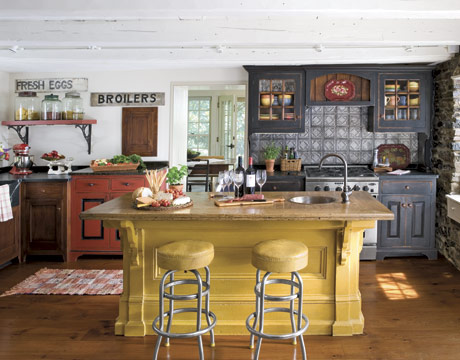

In [22]:
Image.open('style_dataset/processed_images/results/1.jpg')

In [23]:
predict_n_styles('japanese', style_words_dict, w2v_model, 2)

{'art deco': -0.024141936109817991, 'industrial': -0.026769952757938489}

In [24]:
ground_truth_text['japanese']

'minimalist'

In [25]:
for image in os.listdir(TEST_DIRECTORY):
    try:
        print(image, ground_truth_image[image])
    except KeyError:
        print(image, 'is not in ground truth')

.DS_Store is not in ground truth
0.jpg american colonial
102.jpg rustic
108.jpg scandinavian
124.jpg shabby chic
134.jpg traditional
14.jpg bohemian
21.jpg contemporary
27.jpg eclectic
33.jpg industrial
54.jpg century modern
65.jpg minimalist
7.jpg art deco
79.jpg modern
90.jpg nautical


In [26]:
counter = 0
for image in os.listdir('style_dataset/processed_images'):
    try:
        if ground_truth_image[image] == "nautical":
            counter += 1
    except KeyError:
        print(image, 'is not in ground truth')
print('counter: ', counter)

.DS_Store is not in ground truth
results is not in ground truth
test is not in ground truth
counter:  12


## Create a test set

In [35]:
test_set = {}
results_set = {}
for (key, value) in ground_truth_image.items():
    if value in test_set.values():
        results_set[key] = value
    else:
        test_set[key] = value
        

In [38]:
for filename in results_set.keys():
    copy2(os.path.join('style_dataset/processed_images/', filename), os.path.join(RESULTS_DIRECTORY, filename))

In [39]:
for filename in test_set.keys():
    copy2(os.path.join('style_dataset/processed_images/', filename), os.path.join(TEST_DIRECTORY, filename))

## Calculate accuracy on test set

In [29]:
def check_result_image(result, test_image_name):
    print('Ground truth for', test_image_name, 'is', ground_truth_image[test_image_name])
    for (image, prob) in result:
        image_style = ground_truth_image[image]
        print('Prediction:', image_style)
        if image_style == ground_truth_image[test_image_name]:
            return (1, ground_truth_image[test_image_name])
    return (0, ground_truth_image[test_image_name])

In [30]:
def check_result_text(result, word):
    print('Ground truth for', word, 'is', ground_truth_text[word])
    for style in result.keys():
        print('Prediction:', style)
        if style == ground_truth_text[word]:
            return (1, ground_truth_text[word])
    return (0, ground_truth_text[word])

In [31]:
results = {}
def calculate_style_accuracy(test_dir):
    nb_all = 0
    nb_correct = 0
    for image in os.listdir(test_dir):
        try:
            result = vse.find_similar(os.path.join(TEST_DIRECTORY, image), 1)
            (if_correct, truth) = check_result_image(result, image)
            results[truth] = if_correct
            nb_correct += if_correct
            nb_all += 1
        except OSError:
            print('Cannot read image', image)
    print (nb_correct/nb_all)
    return(results)

In [32]:
results_text = {}
def calculate_style_accuracy_text(text_set, nb_results):
    nb_all = 0
    nb_correct = 0
    for word in text_set:
        nb_all += 1
        result = predict_n_styles(word,style_words_dict, w2v_model, nb_results)
        (if_correct, truth) = check_result_text(result, word)
        results_text[truth] = if_correct
        nb_correct += if_correct
    print (nb_correct/nb_all)
    return(results_text)

In [33]:
mixed_results = {}
def text_image_results(text_results, image_results):
    nb_all = 0
    nb_correct = 0
    for style in INTERIOR_STYLES:
        nb_all +=1
        style_text = text_results[style]
        style_image = image_results[style]
        mixed_results[style] = max(style_text, style_image)
        nb_correct += mixed_results[style]
    print(nb_correct/nb_all)
    return mixed_results
        

In [34]:
im_results = calculate_style_accuracy(TEST_DIRECTORY)
print(im_results)

No features for this image found, extracting from CNN
Using model resnet
Cannot read image .DS_Store
No features for this image found, extracting from CNN
Using model resnet
reshaping resnet
extract_features_cnn was completed in 0.26 sec
Ground truth for 0.jpg is american colonial
Prediction: american colonial
No features for this image found, extracting from CNN
Using model resnet
reshaping resnet
extract_features_cnn was completed in 0.26 sec
Ground truth for 102.jpg is rustic
Prediction: industrial
No features for this image found, extracting from CNN
Using model resnet
reshaping resnet
extract_features_cnn was completed in 0.27 sec
Ground truth for 108.jpg is scandinavian
Prediction: scandinavian
No features for this image found, extracting from CNN
Using model resnet
reshaping resnet
extract_features_cnn was completed in 0.34 sec
Ground truth for 124.jpg is shabby chic
Prediction: shabby chic
No features for this image found, extracting from CNN
Using model resnet
reshaping resnet

In [37]:
txt_results = calculate_style_accuracy_text(TEST_SET_TEXT, 1)
print(txt_results)

Ground truth for glamorous is art deco
Prediction: art deco


KeyError: 'avant-garde'

In [38]:
text_image_results(txt_results, im_results)

NameError: name 'txt_results' is not defined